In [1]:
from BcomMEG import *
from TripletMEGDataset import *
from MEGDataset_Conv import *
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
import torch.nn as nn
class BigTripletNet(nn.Module): #this one is designed to take in all the sensors as one big tensor
    def __init__(self):
        super(BigTripletNet, self).__init__()
        
        #Conv Blocks
        self.conv1 = nn.Conv2d(in_channels=20, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(16, 24, 40)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.bn2 = nn.BatchNorm2d(32)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #(32, 12, 20)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #64, 6, 10

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #128, 3, 5

        #FC layers
        self.fc1 = nn.Linear(1920, 512)
        self.fc2 = nn.Linear(512, 128)


    def forward(self, x):
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = self.pool3(self.act3(self.bn3(self.conv3(x))))
        x = self.pool4(self.act4(self.bn4(self.conv4(x))))


        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [9]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
subject = ['BCOM_18_2', 'BCOM_18_3', 'BCOM_18_4']
avoid_reading=True
picks=['MEG 130',
 'MEG 139',
 'MEG 133',
 'MEG 117',
 'MEG 140',
 'MEG 127',
 'MEG 128',
 'MEG 109',
 'MEG 135',
 'MEG 132',
 'MEG 137',
 'MEG 131',
 'MEG 129',
 'MEG 118',
 'MEG 134',
 'MEG 136',
 'MEG 141',
 'MEG 116',
 'MEG 114',
 'MEG 115']

data = BcomMEG(subjects=subject, 
               dir=dir, 
               picks=picks, 
               avoid_reading=True)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [10]:
frequencies = np.array(range(2, 100, 2))
divisor = 5
baseline = (None, 0)
transformed_data = data.get_spectrogram(frequencies=frequencies, 
                            baseline=baseline, 
                            cycle_divisor=divisor,
                            mode='zscore',
                            data_only=True)

NB! Data_only is set to true. To get accurate plots, the extent will have to be set manually, and channels 
will have to be specified as indexes, not names
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s rem

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elaps

Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: zscore)


[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | e

In [11]:
dataset = MEGDataset_Conv(transformed_data, label_map='multi_class_covert')
train_indices, test_indices = train_test_split(
    list(range(len(dataset))), 
    test_size=0.2, 
    random_state=42, 
    stratify=dataset.labels)

train_dataset = TripletMEGDataset(transformed_data, label_map='multi_class_covert', indices=train_indices)
test_dataset = Subset((MEGDataset_Conv(transformed_data, label_map='multi_class_covert', normalize=False)), test_indices)

# Check for common samples
common_samples = set(train_indices).intersection(test_indices)
if common_samples:
    print(f"Common samples found: {common_samples}")
else:
    print("No common samples found")


train_loader = DataLoader(train_dataset, batch_size=13, shuffle=True)
for i, (anchor, positive, negative) in enumerate(train_loader):
    print(f"Batch {i}")
    print("Anchor:", anchor)
    print("Positive:", positive)
    print("Negative:", negative)
    break

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for i, (input,label) in enumerate(test_loader):
    print(f"Batch: {i}")
    print(f"Input: {input}")
    print(f"Label: {label}")
    break

No common samples found
Batch 0
Anchor: tensor([[[[-7.5498e-01, -7.0667e-01, -5.6509e-01,  ...,  1.0634e+01,
            1.6019e+01,  1.6558e+01],
          [-1.2258e+00, -1.2226e+00, -1.1260e+00,  ...,  1.0195e+01,
            1.3432e+01,  1.2987e+01],
          [-1.6470e+00, -1.6803e+00, -1.6385e+00,  ...,  7.9219e+00,
            9.0078e+00,  7.8905e+00],
          ...,
          [-5.8597e-01, -4.6206e-01, -4.4881e-01,  ..., -8.8553e-01,
           -1.1603e+00, -1.3395e+00],
          [-6.3170e-01, -5.1429e-01, -5.6168e-01,  ..., -1.1953e+00,
           -1.3280e+00, -1.4197e+00],
          [-6.2713e-01, -5.1394e-01, -5.9092e-01,  ..., -1.3849e+00,
           -1.4272e+00, -1.4574e+00]],

         [[ 5.1953e-02,  2.3669e-01, -1.7215e-01,  ..., -1.0240e+00,
           -3.7352e-01,  1.1779e-01],
          [-6.2294e-01, -3.4631e-01, -5.1967e-01,  ..., -1.3282e+00,
           -8.4531e-01, -5.0921e-01],
          [-1.1861e+00, -8.9358e-01, -8.2899e-01,  ..., -1.4440e+00,
           -1.1908

In [23]:
from sklearn.preprocessing import normalize
torch.manual_seed(0)
model = BigTripletNet()
device = 'mps'
model = model.to(device=device)
criterion = nn.TripletMarginLoss(margin=5.0, p=2, eps=1e-7) #profile 1 (20 sensors): 5.0, 2, 1e-7  #profile 2 (20 sensors): 2.0, 2, 1e-7
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 35 #profile 1: 25 #profile 2: 25
total_steps = len(train_loader)

loss_values = []
model.train()
for epoch in range(epochs):
    for i, (anchor, positive, negative) in enumerate(train_loader):
    
        anchor, positive, negative = anchor.to(device, dtype=torch.float32),positive.to(device, dtype=torch.float32), negative.to(device, dtype=torch.float32)
        
        optimizer.zero_grad()
        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)

        loss = criterion(anchor_embedding, positive_embedding, negative_embedding)

        
        loss.backward()
        optimizer.step()
        

        loss_values.append(loss.item())

        if (i+1) % 10 == 0:  # Adjusted the condition to a smaller number
            print(f'Epoch [{epoch + 1} / {epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.6f}')
print('Training Finished')


Epoch [1 / 35], Step [10/37], Loss: 4.871547
Epoch [1 / 35], Step [20/37], Loss: 5.151953
Epoch [1 / 35], Step [30/37], Loss: 5.599083
Epoch [2 / 35], Step [10/37], Loss: 5.317804
Epoch [2 / 35], Step [20/37], Loss: 5.841885
Epoch [2 / 35], Step [30/37], Loss: 4.642670
Epoch [3 / 35], Step [10/37], Loss: 4.733790
Epoch [3 / 35], Step [20/37], Loss: 5.332354
Epoch [3 / 35], Step [30/37], Loss: 5.281039
Epoch [4 / 35], Step [10/37], Loss: 4.441576
Epoch [4 / 35], Step [20/37], Loss: 4.866273
Epoch [4 / 35], Step [30/37], Loss: 5.081671
Epoch [5 / 35], Step [10/37], Loss: 4.410292
Epoch [5 / 35], Step [20/37], Loss: 4.900003
Epoch [5 / 35], Step [30/37], Loss: 5.564867
Epoch [6 / 35], Step [10/37], Loss: 4.052852
Epoch [6 / 35], Step [20/37], Loss: 4.546761
Epoch [6 / 35], Step [30/37], Loss: 3.600955
Epoch [7 / 35], Step [10/37], Loss: 4.228201
Epoch [7 / 35], Step [20/37], Loss: 4.199594
Epoch [7 / 35], Step [30/37], Loss: 4.997350
Epoch [8 / 35], Step [10/37], Loss: 4.850826
Epoch [8 /

In [24]:
#Compute embeddings for KNN
train_clustering = Subset(MEGDataset_Conv(transformed_data, label_map='multi_class_covert'), train_indices)
clustering_loader = DataLoader(train_clustering, batch_size=1)

clustering_embeddings = []
clustering_labels = []

model.eval()

with torch.no_grad():
    for i, (inputs, label) in enumerate(clustering_loader):
        inputs = inputs.to(device, dtype=torch.float32)
        embeddings = model(inputs)
        clustering_embeddings.append(embeddings.cpu().numpy())
        clustering_labels.append(label.cpu().numpy())

clustering_embeddings = normalize(np.concatenate(clustering_embeddings, axis=0))
clustering_labels = np.concatenate(clustering_labels, axis=0)

test_embeddings = []
test_labels = []
with torch.no_grad():
    true_labels = []
    for i, (inputs, label) in enumerate(test_loader):
        inputs = inputs.to(device, dtype=torch.float32)
        embeddings = model(inputs)
        test_embeddings.append(embeddings.cpu().numpy())
        test_labels.append(label.cpu().numpy())

test_embeddings = normalize(np.concatenate(test_embeddings, axis=0))
test_labels = np.concatenate(test_labels, axis=0)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
k = 5 #profile 1: 1 #profile 2: 10
knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')  # Euclidean distance in embedding space

# Train KNN on training embeddings
knn.fit(clustering_embeddings, clustering_labels)

# Convert test embeddings to numpy array
test_embeddings = test_embeddings

# Predict labels for test embeddings
predicted_labels = knn.predict(test_embeddings)

# Evaluate accuracy
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='weighted')

print(f"KNN Accuracy: {accuracy * 100:.2f}%")
print(f"KNN F1 Score: {f1 * 100:.2f}")

KNN Accuracy: 4.13%
KNN F1 Score: 3.38


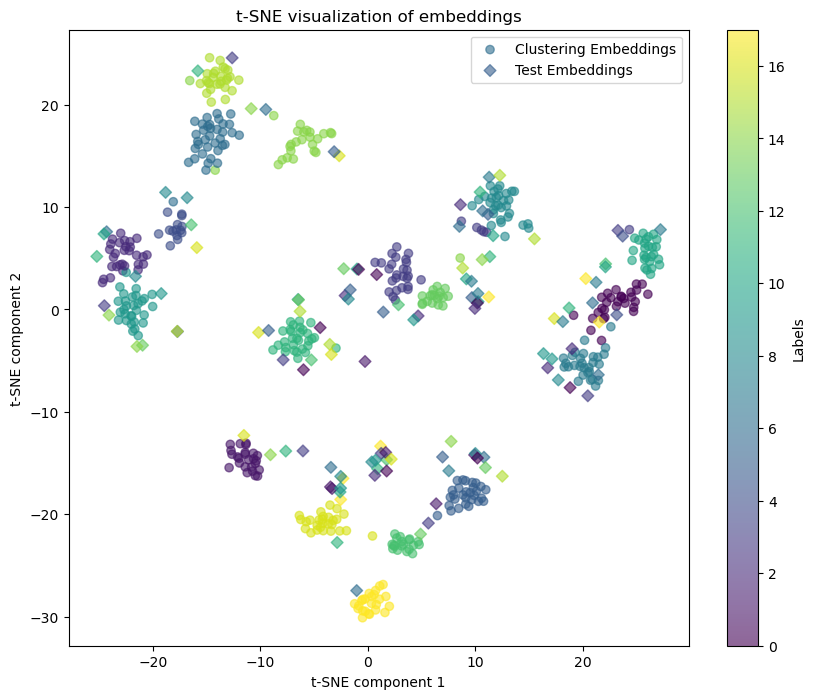

In [26]:
# Combine clustering and test embeddings for visualization
from sklearn.manifold import TSNE

# Combine embeddings and labels
all_embeddings = np.concatenate((clustering_embeddings, test_embeddings), axis=0)
all_labels = np.concatenate((clustering_labels, test_labels), axis=0)

# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings)

# Split t-SNE results for clustering and test embeddings
clustering_tsne = tsne_results[:len(clustering_embeddings)]
test_tsne = tsne_results[len(clustering_embeddings):]

# Plot the results
plt.figure(figsize=(10, 8))

# Plot clustering embeddings
scatter_clustering = plt.scatter(
    clustering_tsne[:, 0], clustering_tsne[:, 1],
    c=clustering_labels, cmap='viridis', alpha=0.6, marker='o', label='Clustering Embeddings'
)

# Plot test embeddings
scatter_test = plt.scatter(
    test_tsne[:, 0], test_tsne[:, 1],
    c=test_labels, cmap='viridis', alpha=0.6, marker='D', label='Test Embeddings'
)

# Add legend and colorbar
plt.colorbar(scatter_clustering, label='Labels')
plt.legend(loc='best')
plt.title('t-SNE visualization of embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()